# **데이터 준비**

In [1]:
# 작업 경로 설정
import os
os.chdir('/content/drive/MyDrive/DataDreamworks/DataAnalysis_Marketing/clv_commerce')
#cd /content/drive/MyDrive/DataDreamworks/DataAnalysis_Marketing/clv_commerce

In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# raw data 불러오기

df = pd.read_excel('clv_table_2014.xlsx')
df.loc[:3]

,customer id,purchase_value,purchase_freq,lifespan,customer_clv,first_order_date,second_order_date,first_order_sales,second_order_sales
0,BH-11710,2.5689,0.0038,0.3077,0.003,2014-06-09,2014-11-11,3714.30,808.93
1,PK-19075,0.3764,0.0013,0.0000,0.000,2014-11-11,NaT,665.88,NaN
2,AG-10270,0.0879,0.0025,0.0895,0.000,2014-05-13,2014-07-23,55.50,99.98
3,ZD-21925,0.1384,0.0013,0.0000,0.000,2014-08-27,NaT,244.76,NaN


In [3]:
# 모든 고객수
print(f'2014년 상반기에 주문한 고객수: {len(df)} 명')

# 한 번만 주문한 고객 정보 제거하기
df = df[~df['second_order_date'].isna()]

print(f'2014년 상반기에 2번 이상 주문한 고객수: {len(df)} 명')

2014년 상반기에 주문한 고객수: 590 명
2014년 상반기에 2번 이상 주문한 고객수: 257 명


In [4]:
len(df)

257

In [5]:
# df 구성 데이터 확인하기
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257 entries, 0 to 586
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer id         257 non-null    object        
 1   purchase_value      257 non-null    float64       
 2   purchase_freq       257 non-null    float64       
 3   lifespan            257 non-null    float64       
 4   customer_clv        257 non-null    float64       
 5   first_order_date    257 non-null    datetime64[ns]
 6   second_order_date   257 non-null    datetime64[ns]
 7   first_order_sales   257 non-null    float64       
 8   second_order_sales  257 non-null    float64       
dtypes: datetime64[ns](2), float64(6), object(1)
memory usage: 20.1+ KB


In [6]:
# 첫 주문일부터 두번째 주문일까지의 소요기간 구하기
df['datediff'] = (df['second_order_date'] - df['first_order_date']).dt.days

# **데이터 분포 확인**

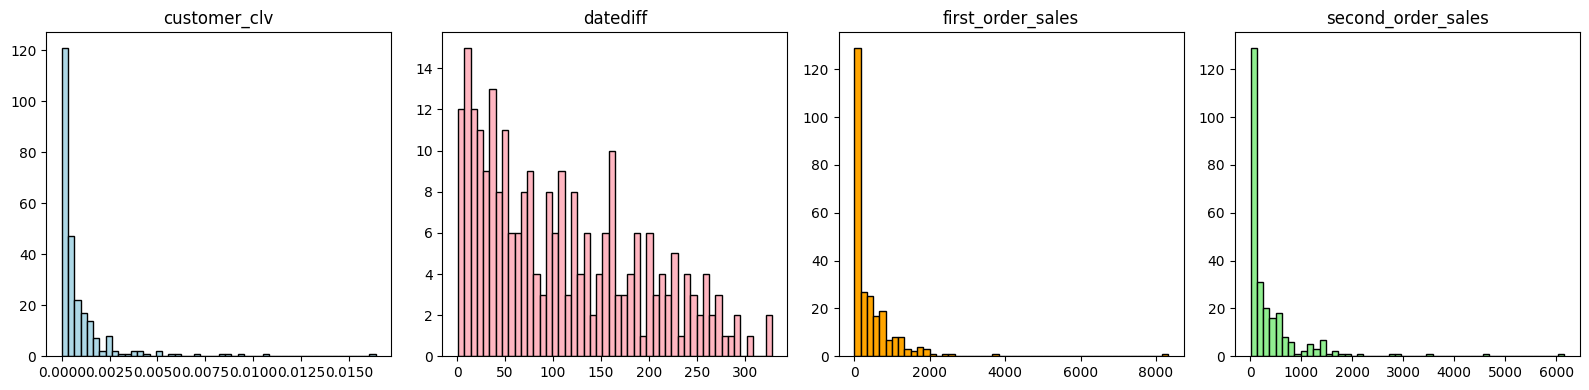

In [7]:
# 데이터 분포 확인
from matplotlib import pyplot as plt
import numpy as np

plot_columns = ['customer_clv', 'datediff', 'first_order_sales', 'second_order_sales']
plot_distribution = df[plot_columns]

def plot_check(plot_columns, plot_distribution):

  # 분포 시각화
  plt.figure(figsize=(16, 4))

  for idx, numeric in enumerate(plot_columns) :
      col = ['lightblue', 'lightpink', 'orange', 'lightgreen']

      plt.subplot(1, 4, idx+1)
      plt.hist(plot_distribution[numeric], bins=50, color=col[idx], edgecolor='black')
      plt.title(numeric)
      plt.tight_layout()

  plt.tight_layout()
  plt.show()

plot_check(plot_columns, plot_distribution)

In [8]:
# Log 변환
df['Log_customer_clv'] = np.log(df['customer_clv'] + 0.001)
df['Log_datediff'] = np.log(df['datediff'] + 1)
df['Log_first_order_sales'] = np.log(df['first_order_sales'] + 1)
df['Log_second_order_sales'] = np.log(df['second_order_sales'] + 1)

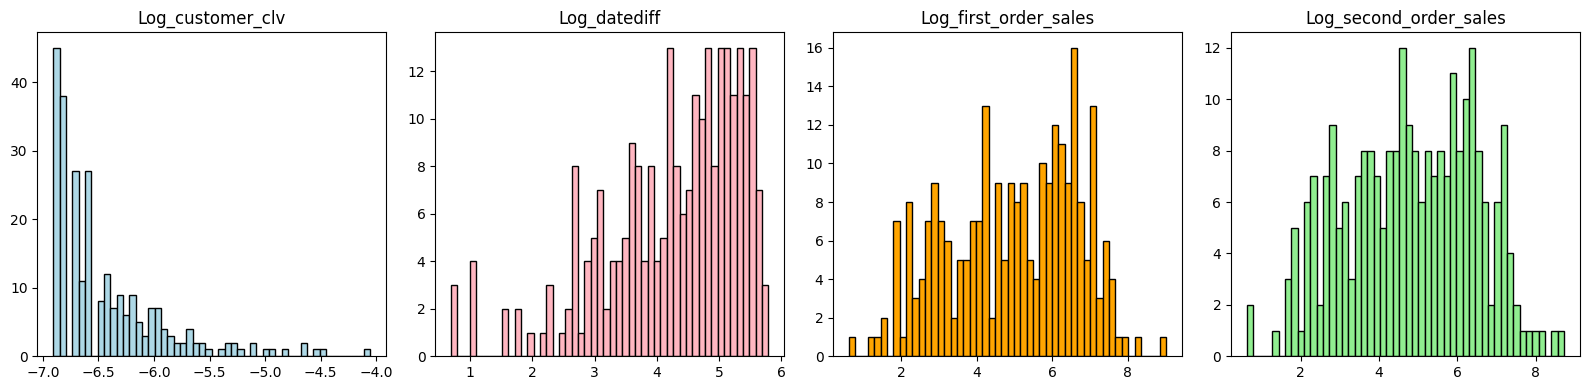

In [9]:
# Log 변환한 데이터 분포 확인
plot_columns = ['Log_customer_clv', 'Log_datediff', 'Log_first_order_sales', 'Log_second_order_sales']
plot_distribution = df[plot_columns]

plot_check(plot_columns, plot_distribution)

In [10]:
# StandardScaling 변환하기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Scaled_customer_clv', 'Scaled_datediff', 'Scaled_first_order_sales', 'Scaled_second_order_sales']] = scaler.fit_transform(df[['customer_clv', 'datediff', 'first_order_sales', 'second_order_sales']])

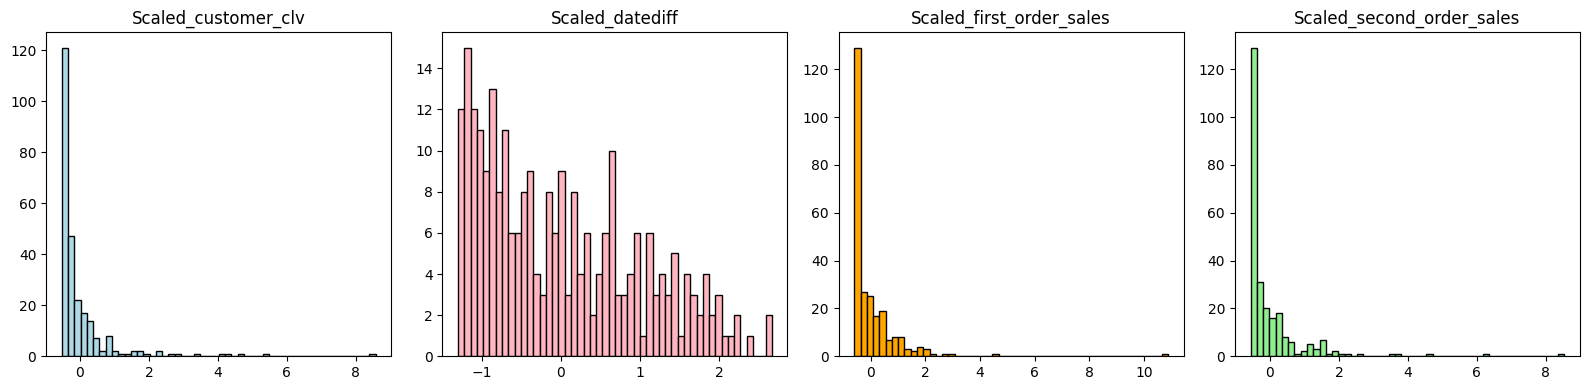

In [11]:
# StandardScaling 변환한 데이터 분포 확인
plot_columns = ['Scaled_customer_clv', 'Scaled_datediff', 'Scaled_first_order_sales', 'Scaled_second_order_sales']
plot_distribution = df[plot_columns]

plot_check(plot_columns, plot_distribution)

# **다중공선성 확인**
- "변환하지 않은 값", "Log 변환값", "Standard Scaling 변환값" 중에서 "Log 변환값"은 VIF 값이 5 이상이므로 다중공선성의 문제가 있음. 즉, 선형회귀 모델은 사용할 수 없음

- <mark>**따라서 모델링 할 때, Log 변환값이 아닌 Standard Scaling 변환값을 사용**</mark>

In [23]:
# 변환하지 않은 데이터들로 다중공선성 확인하기
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# 독립변수 설정
X = df[['datediff', 'first_order_sales', 'second_order_sales']]

# VIF 데이터프레임 생성
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# 각 feature에 대한 VIF 계산
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# VIF 결과 출력
print(vif_data) # 모든 독립변수가 5 이하 이므로 다중공선성 문제 없음 -> 선형회귀 모델 사용 가능

              feature       VIF
0            datediff  1.382547
1   first_order_sales  1.198515
2  second_order_sales  1.277806


In [25]:
# log로 변환한 데이터들로 다중공선성 확인하기
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# 독립변수 설정
X = df[['Log_datediff', 'Log_first_order_sales', 'Log_second_order_sales']]

# VIF 데이터프레임 생성
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# 각 feature에 대한 VIF 계산
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# VIF 결과 출력
print(vif_data) # 모든 독립변수가 5 이상 이므로 다중공선성 문제 있음 -> 선형회귀 모델 사용하면 안됨

                  feature       VIF
0            Log_datediff  9.369950
1   Log_first_order_sales  7.607240
2  Log_second_order_sales  7.504114


In [26]:
# Standard Scaling한 데이터로 다중공선성 확인하기

# 독립변수 설정
X = df[['datediff', 'first_order_sales', 'second_order_sales']]

# 데이터를 표준화 (StandardScaler) - VIF는 데이터의 스케일에 민감하지 않지만, 일반적으로 스케일을 맞추면 안정적인 계산이 가능
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# VIF 데이터프레임 생성
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# 각 feature에 대한 VIF 계산
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# VIF 결과 출력
print(vif_data) # 모든 독립변수가 5 이하 이므로 다중공선성 문제 없음 -> 선형회귀 모델 사용해도 됨

              feature       VIF
0            datediff  1.015437
1   first_order_sales  1.003965
2  second_order_sales  1.015644


# **상관관계 확인**
- 모든 값이 0에 가까우므로 상관관계가 높은 변수들 없음
- 그나마 second_order_sales와 customer_clv가 아주 약한 상관관계(0.26)를 가질 수도 있을 것이라 판단됨

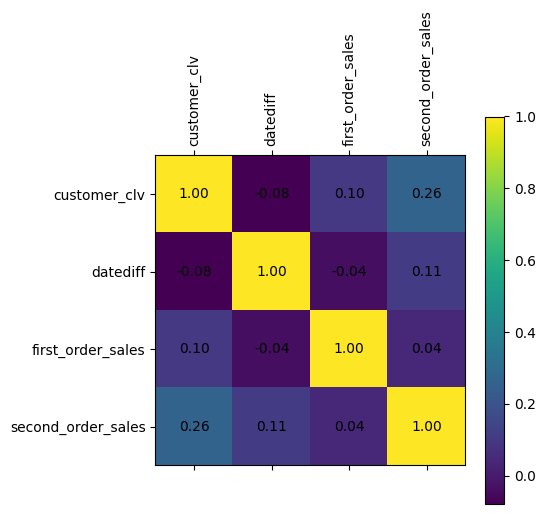

In [28]:
# 변수들의 상관관계 확인
cor_columns = ['customer_clv', 'datediff', 'first_order_sales', 'second_order_sales']
cor_data = df[cor_columns]

# 상관관계 메트릭스
correlation_matrix = cor_data.corr()

# 상관관계 메트릭스 시각화
plt.figure(figsize=(5, 5))

plt.matshow(correlation_matrix, fignum=1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

for (i, j), val in np.ndenumerate(correlation_matrix):
    plt.text(j, i, '{:0.2f}'.format(val), ha='center', va='center', color='black')

plt.show()

# **CLV 값을 예측하는 모델 구축하기**


## **방법 1) customer_clv 값을 예측하는 모델 구축 후, 성능 검토**
- <mark>**모든 모델의 R2 값이 절대값 0.2 이하이므로, 모든 모델의 설명력이 낮음. 즉, 각 모델은 데이터의 분포를 잘 설명할 수 없음**</mark>

In [29]:
# 필요한 페키지 불러오기
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

In [30]:
# 독립변수 설정
X = df[['datediff', 'first_order_sales', 'second_order_sales']]
# 종속변수 설정
y = df['customer_clv']

# train, test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# 결과 저장할 dict 생성
results = {}

# -------------------- Linear Regression --------------------
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
results['Linear Regression'] = {'MSE': mse_linear, 'R2': r2_linear}

# -------------------- Random Forest --------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
results['Random Forest'] = {'MSE': mse_rf, 'R2': r2_rf}

# -------------------- Gradient Boosting --------------------
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
results['Gradient Boosting'] = {'MSE': mse_gb, 'R2': r2_gb}

# -------------------- XGBoost --------------------
#xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)

xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
results['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb}

In [32]:
# 모든 모델의 R2 값이 너무 낮으므로 모든 모델의 설명력이 안 좋음 -> 각 모델은 데이터를 잘 설명할 수 없음
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R-squared: {metrics['R2']}")
    print()

Linear Regression:
  MSE: 1.957303514542591e-06
  R-squared: 0.13027459516061368

Random Forest:
  MSE: 2.238599173076923e-06
  R-squared: 0.005281215911761117

Gradient Boosting:
  MSE: 2.299593136377003e-06
  R-squared: -0.021821376522053404

XGBoost:
  MSE: 2.1417835091782015e-06
  R-squared: 0.048301136866017114



## **방법 2) 상위 30%의 customer_clv는 1로, 그 이외의 값은 0을 예측하는 모델 구축 후, 성능 검토**
- <mark>**F1-score로 모델의 성능을 판단했을 때, Logistic Regression 모델의 성능이 가장 뛰어남 (Acc : 59.62% / F1-score : 36.36%)**</mark>
   - 지도학습 모델
    - Logistic Regression Model : Acc : 59.62% / F1-score : 36.36%
    - Random Forest Model : Acc : 55.77% / F1-score : 30%
    - Gradient Boosting Model : Acc : 61.54% / F1-score : 16.67%
   - 비지도학습 모델
    - Isolation Forest Model : Acc : 0% / F1-score : 0%


### **지도학습 모델 : Logistic Regression, Random Forest, Gradient Boosting**

In [39]:
# 필요한 페키지 불러오기
!pip install -U imbalanced-learn

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [40]:
# clv가 상위 30%인 값 확인하기
threshold_30 = df['customer_clv'].quantile(0.70)

# clv_class_30 컬럼 만들기: 상위 30%인 clv 값은 1로 변환하고, 그 이외의 값은 0으로 변환하기
df['clv_class_30'] = (df['customer_clv'] > threshold_30).astype(int)

In [41]:
# clv가 상위 30%인 값 확인하기
threshold_30

0.0008

In [42]:
# clv_class_30 컬럼의 구성 살펴보기
df['clv_class_30'].value_counts()

,count
clv_class_30,
0,184
1,73


In [43]:
# X값과 y값 설정하기
X = df[['Scaled_first_order_sales', 'Scaled_second_order_sales', 'Scaled_datediff']]
y = df['clv_class_30']  # 이진분류 값으로 구성된 타겟

# train/test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# y값이 0에 치우쳐있음 -> smote를 활용하여 타겟값이 1인 경우 upsampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [45]:
# Logistic Regression 모델 구축하고, 성능 평가하기
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_smote, y_train_smote)

y_pred_logistic = logistic_model.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
report_logistic = classification_report(y_test, y_pred_logistic)

print(f"Logistic Regression Accuracy: {accuracy_logistic}")
print("Logistic Regression Classification Report:\n", report_logistic)

Logistic Regression Accuracy: 0.5961538461538461
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.62      0.70        40
           1       0.29      0.50      0.36        12

    accuracy                           0.60        52
   macro avg       0.55      0.56      0.53        52
weighted avg       0.69      0.60      0.63        52



In [46]:
# Random Forest 모델 구축하고, 성능 평가하기
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf}")
print("Random Forest Classification Report:\n", report_rf)


Random Forest Accuracy: 0.5576923076923077
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.60      0.68        40
           1       0.24      0.42      0.30        12

    accuracy                           0.56        52
   macro avg       0.51      0.51      0.49        52
weighted avg       0.65      0.56      0.59        52



In [47]:
# Gradient Boosting Classifier 모델 구축하고, 성능 평가하기
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate Gradient Boosting
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)

print(f"Gradient Boosting Accuracy: {accuracy_gb}")
print("Gradient Boosting Classification Report:\n", report_gb)


Gradient Boosting Accuracy: 0.6153846153846154
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        40
           1       0.17      0.17      0.17        12

    accuracy                           0.62        52
   macro avg       0.46      0.46      0.46        52
weighted avg       0.62      0.62      0.62        52



### **비지도 학습 모델 : Isolation Forest**

In [48]:
# Isolation Forest 모델 구축하고, 성능 평가하기
n_estimators = 100
max_samples = 'auto'
contamination = 'auto'
#contamination = num_Fraud/(num_Normal+num_Fraud)

# Isolation Forest 생성 및 학습
from sklearn.ensemble import IsolationForest

seed = 1234

IForest = IsolationForest(n_estimators=n_estimators,
                          max_samples=max_samples,
                          contamination=contamination,
                          random_state=seed)
IForest.fit(X_train)

IsolationForest(random_state=1234)

In [50]:
y_pred_iforest = IForest.predict(X_test)
y_pred_iforest = np.where(y_test == 1, 0, 1)

In [51]:
# 성능 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_iforest)
precision = precision_score(y_test, y_pred_iforest)
recall = recall_score(y_test, y_pred_iforest)
f1 = f1_score(y_test, y_pred_iforest)

print(f'정확도 Accuracy : {accuracy*100:.2f} %')
print(f'정밀도 Precision : {precision*100:.2f} %')
print(f'재현율 Recall : {recall*100:.2f} %')
print(f'F1 : {f1*100:.2f} %')

정확도 Accuracy : 0.00 %
정밀도 Precision : 0.00 %
재현율 Recall : 0.00 %
F1 : 0.00 %


### **지도학습 모델과 비지도학습 모델 성능 비교하기**

In [55]:
models = [y_pred_logistic, y_pred_rf, y_pred_gb, y_pred_iforest]
models_name = ['Supervised Model - Logistic Regression Model',
               'Supervised Model - Random Forest Model',
               'Supervised Model - Gradient Boosting Model',
               'Unsupervised Model - Isolation Forest Model']

for s in range(len(models)):
  accuracy = accuracy_score(y_test, models[s])
  precision = precision_score(y_test, models[s])
  recall = recall_score(y_test, models[s])
  f1 = f1_score(y_test, models[s])

  print(models_name[s])
  print("\n")
  print(f'정확도 Accuracy : {accuracy*100:.2f} %')
  print(f'정밀도 Precision : {precision*100:.2f} %')
  print(f'재현율 Recall : {recall*100:.2f} %')
  print(f'F1 : {f1*100:.2f} %')
  print("\n")

Supervised Model - Logistic Regression Model


정확도 Accuracy : 59.62 %
정밀도 Precision : 28.57 %
재현율 Recall : 50.00 %
F1 : 36.36 %


Supervised Model - Random Forest Model


정확도 Accuracy : 55.77 %
정밀도 Precision : 23.81 %
재현율 Recall : 41.67 %
F1 : 30.30 %


Supervised Model - Gradient Boosting Model


정확도 Accuracy : 61.54 %
정밀도 Precision : 16.67 %
재현율 Recall : 16.67 %
F1 : 16.67 %


Unsupervised Model - Isolation Forest Model


정확도 Accuracy : 0.00 %
정밀도 Precision : 0.00 %
재현율 Recall : 0.00 %
F1 : 0.00 %




### **분류모델 성능평가 - Confusion Matrix**

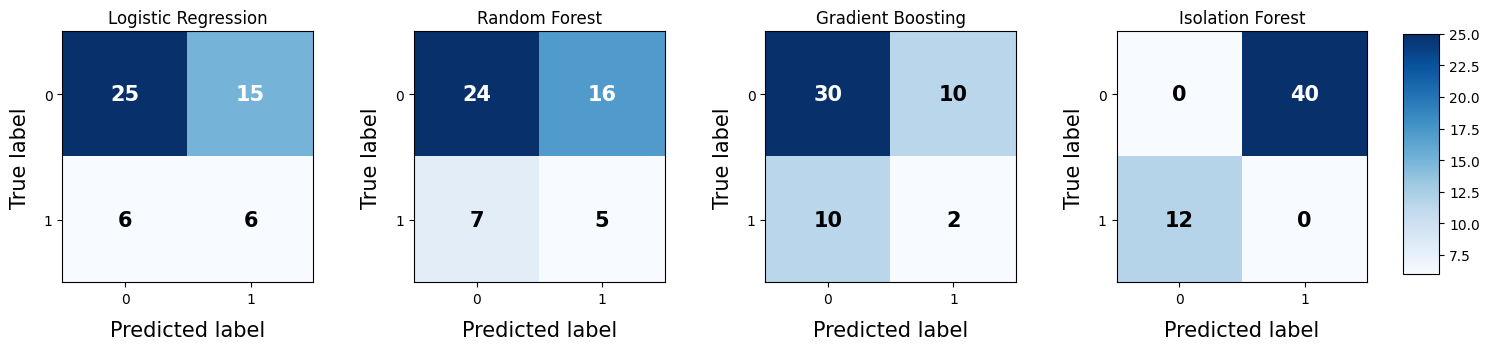

In [126]:
# Confusion matrices 생성
conf_matrix_log = confusion_matrix(y_test, y_pred_logistic)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
conf_matrix_if = confusion_matrix(y_test, y_pred_iforest)

# 1 X 4 subplot 만들기
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Logistic Regression Model - Confusion Matrix
im1 = axes[0].imshow(conf_matrix_log, cmap=plt.cm.Blues)
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted label', size=15, labelpad=10)
axes[0].set_ylabel('True label', size=15, labelpad=10)
axes[0].set_xticks(range(2))
axes[0].set_yticks(range(2))
axes[0].set_xticklabels([0, 1])
axes[0].set_yticklabels([0, 1])


# Random Forest Model - Confusion Matrix
im2 = axes[1].imshow(conf_matrix_rf, cmap=plt.cm.Blues)
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted label', size=15, labelpad=10)
axes[1].set_ylabel('True label', size=15, labelpad=10)
axes[1].set_xticks(range(2))
axes[1].set_yticks(range(2))
axes[1].set_xticklabels([0, 1])
axes[1].set_yticklabels([0, 1])

# Gradient Boosting Model - Confusion Matrix
im3 = axes[2].imshow(conf_matrix_gb, cmap=plt.cm.Blues)
axes[2].set_title('Gradient Boosting')
axes[2].set_xlabel('Predicted label', size=15, labelpad=10)
axes[2].set_ylabel('True label', size=15, labelpad=10)
axes[2].set_xticks(range(2))
axes[2].set_yticks(range(2))
axes[2].set_xticklabels([0, 1])
axes[2].set_yticklabels([0, 1])

# Isolation Forest Model - Confusion Matrix
im4 = axes[3].imshow(conf_matrix_if, cmap=plt.cm.Blues)
axes[3].set_title('Isolation Forest')
axes[3].set_xlabel('Predicted label', size=15, labelpad=10)
axes[3].set_ylabel('True label', size=15, labelpad=10)
axes[3].set_xticks(range(2))
axes[3].set_yticks(range(2))
axes[3].set_xticklabels([0, 1])
axes[3].set_yticklabels([0, 1])

# 각 셀에 값을 텍스트로 추가
for ax, cm in zip(axes, [conf_matrix_log, conf_matrix_rf, conf_matrix_gb, conf_matrix_if]):
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='white' if val > cm.max() / 2 else 'black', size=15, weight='bold')

# 하나의 colorbar를 subplot 전체에 추가하고 오른쪽에 배치
fig.subplots_adjust(right=0.85, wspace=0.4)  # wspace를 추가하여 subplot 간 간격을 조정
cbar_ax = fig.add_axes([0.87, 0.3, 0.02, 0.4]) # colorbar 위치와 크기 조정 (왼쪽, 아래, 넓이, 높이)
fig.colorbar(im1, cax=cbar_ax)


# Layout 설정
#plt.tight_layout(rect=[0, 0, 0.85, 1])  # right를 0.85로 설정해 색상표 공간 확보
plt.show()

### **최적화 분류모델 찾기**
- <mark>**최적의 파라미터를 찾았을 때도 Random Forest Classifier Model의 성능이 가장 뛰어났음 (Acc : 91.8% / F1-score : 86%)**<mark>
   - Logistic Regression - Acc: 62.7% / F1-score : 44.8%
   - Random Forest Classifier - Acc : 91.8% / F1-score : 86%
   - Gradient Boosting Classifier - Acc : 87.6% / F1-score : 80%


In [133]:
from imblearn.pipeline import Pipeline  # Imbalanced-learn의 Pipeline 사용
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 각 모델에 대한 파라미터 그리드 설정
param_grid = [
    {
        'model': [LogisticRegression(random_state=42, class_weight='balanced')],
        'model__C': [0.01, 0.1, 1, 10],  # Logistic Regression에만 적용될 파라미터
    },
    {
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [100, 200],  # RandomForest에만 적용될 파라미터
        'model__max_depth': [5, 10]
    },
    {
        'model': [GradientBoostingClassifier(random_state=42)],
        'model__n_estimators': [100, 200],  # GradientBoosting에만 적용될 파라미터
        'model__learning_rate': [0.01, 0.1]
    }
]

# Pipeline 생성: SMOTETomek + 모델 (Imbalanced-learn의 Pipeline 사용)
pipeline = Pipeline([
    ('smote_tomek', SMOTETomek(random_state=42)),
    ('model', LogisticRegression(random_state=42, class_weight='balanced'))  # 기본 모델을 LogisticRegression으로 설정
])

# GridSearchCV 실행
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='f1', n_jobs=-1)

# Features (X) and target (y)
X = df[['Scaled_first_order_sales', 'Scaled_second_order_sales', 'Scaled_datediff']]
y = df['clv_class_30']  # Binary classification target

# 모델 학습 및 검증
grid_search.fit(X, y)

# 각 모델에서 가장 성능이 좋았던 결과를 저장할 리스트
best_logistic = None
best_rf = None
best_gb = None

# 각 모델의 성능과 최적 하이퍼파라미터 출력 및 성능 지표 계산
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    mean_f1 = grid_search.cv_results_['mean_test_score'][i]

    # 모델별로 최적의 결과를 저장
    if isinstance(params['model'], LogisticRegression):
        if best_logistic is None or mean_f1 > best_logistic['mean_f1']:
            best_logistic = {
                'model': params['model'],
                'params': params,
                'mean_f1': mean_f1,
                'std_f1': grid_search.cv_results_['std_test_score'][i]
            }
    elif isinstance(params['model'], RandomForestClassifier):
        if best_rf is None or mean_f1 > best_rf['mean_f1']:
            best_rf = {
                'model': params['model'],
                'params': params,
                'mean_f1': mean_f1,
                'std_f1': grid_search.cv_results_['std_test_score'][i]
            }
    elif isinstance(params['model'], GradientBoostingClassifier):
        if best_gb is None or mean_f1 > best_gb['mean_f1']:
            best_gb = {
                'model': params['model'],
                'params': params,
                'mean_f1': mean_f1,
                'std_f1': grid_search.cv_results_['std_test_score'][i]
            }

# 각 모델별로 최적 모델로 성능 지표 계산
for best_model_info in [best_logistic, best_rf, best_gb]:
    model_pipeline = Pipeline([
        ('smote_tomek', SMOTETomek(random_state=42)),
        ('model', best_model_info['model'])
    ])
    model_pipeline.fit(X, y)
    y_pred = model_pipeline.predict(X)

    # 성능 지표 계산
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f"{best_model_info['model'].__class__.__name__} 최적 모델:")
    print(f"최적 파라미터: {best_model_info['params']}")
    print(f"평균 F1 Score (Cross-validation): {best_model_info['mean_f1']:.4f} ± {best_model_info['std_f1']:.4f}")
    print(f'정확도 Accuracy: {accuracy:.4f}')
    print(f'정밀도 Precision: {precision:.4f}')
    print(f'재현율 Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print("-" * 50)

# 세 모델 중 성능이 가장 좋은 모델 선택 (실제 성능 지표인 F1 Score를 기준으로)
best_overall_model = max([best_logistic, best_rf, best_gb], key=lambda x: f1_score(y, Pipeline([
    ('smote_tomek', SMOTETomek(random_state=42)),
    ('model', x['model'])
]).fit(X, y).predict(X)))

# 최종 최적 모델 성능 출력
print("가장 성능이 좋은 모델:")
model_pipeline = Pipeline([
    ('smote_tomek', SMOTETomek(random_state=42)),
    ('model', best_overall_model['model'])
])
model_pipeline.fit(X, y)
y_pred = model_pipeline.predict(X)

# 최종 성능 지표 계산
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print(f"모델: {best_overall_model['model'].__class__.__name__}")
print(f"최적 파라미터: {best_overall_model['params']}")
print(f"정확도 Accuracy: {accuracy:.4f}")
print(f"정밀도 Precision: {precision:.4f}")
print(f"재현율 Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

LogisticRegression 최적 모델:
최적 파라미터: {'model': LogisticRegression(class_weight='balanced', random_state=42), 'model__C': 1}
평균 F1 Score (Cross-validation): 0.4031 ± 0.1359
정확도 Accuracy: 0.6265
정밀도 Precision: 0.3861
재현율 Recall: 0.5342
F1 Score: 0.4483
--------------------------------------------------
RandomForestClassifier 최적 모델:
최적 파라미터: {'model': RandomForestClassifier(random_state=42), 'model__max_depth': 5, 'model__n_estimators': 200}
평균 F1 Score (Cross-validation): 0.3625 ± 0.1717
정확도 Accuracy: 0.9183
정밀도 Precision: 0.8333
재현율 Recall: 0.8904
F1 Score: 0.8609
--------------------------------------------------
GradientBoostingClassifier 최적 모델:
최적 파라미터: {'model': GradientBoostingClassifier(random_state=42), 'model__learning_rate': 0.01, 'model__n_estimators': 100}
평균 F1 Score (Cross-validation): 0.4013 ± 0.0859
정확도 Accuracy: 0.8755
정밀도 Precision: 0.7356
재현율 Recall: 0.8767
F1 Score: 0.8000
--------------------------------------------------
가장 성능이 좋은 모델:
모델: RandomForestClassifier
최적 파라미

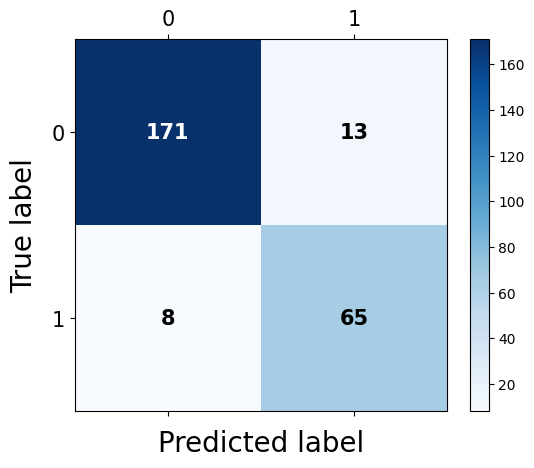

In [134]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

result_cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6, 6))

plt.matshow(result_cm, fignum=1, cmap=plt.cm.Blues)
plt.xticks(range(2), [0, 1], size=15)
plt.yticks(range(2), [0, 1], size=15)
plt.ylabel('True label', size=20, labelpad=10)
plt.xlabel('Predicted label', size=20, labelpad=10)

# shrink 값을 조정하여 colorbar 크기 줄임
plt.colorbar(shrink=0.8)

# 각 셀에 텍스트 추가 (값에 따라 색 변경)
for (i, j), val in np.ndenumerate(result_cm):
    color = 'white' if val > 80 else 'black'
    plt.text(j, i, f'{val}', ha='center', va='center', color=color, size=15, weight='bold')

plt.show()

